# Обучение и отбор модели.

In [106]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

In [107]:
import pandas as pd
import numpy as np
import gc
import warnings
from sklearn import (ensemble, model_selection, discriminant_analysis,
                     naive_bayes, linear_model, neighbors, tree, svm, metrics)
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from functools import partial
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
import shap

gc.enable()
warnings.filterwarnings("ignore")


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Функция теста модели.

In [130]:
def model_test(model, x_train, x_valid, y_train, y_true):
    clf = model
    clf.fit(x_train, y_train)
    f1 = metrics.f1_score(y_true, clf.predict(x_valid), average="binary")
    name = (
        str(clf)[:str(clf).rfind('(')]
        if "CatBoostClassifier" not in str(clf) else "CatBoostClassifier"
    )
    with open("default_models.txt", 'a', encoding="utf-8") as file:
        file.write(f"{name}: {round(f1, 5)}\n")

In [109]:
df = pd.read_csv("data/scoring_processed.csv")

In [110]:
df.shape

(128259, 11)

In [111]:
df.sample(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
6672,0,0.559000,0,0.700117,2560.000000,6,0,0,0.0,A,d
20839,0,0.700700,0,0.283219,8300.000000,6,0,0,2.0,A,d
108052,0,0.079650,0,1949.000000,262.000000,3,0,0,0.0,A,d
80604,0,0.012924,0,0.296469,5153.000000,7,0,0,0.0,A,d
4277,0,0.355200,0,1265.000000,61.511744,9,0,0,0.0,A,d


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128259 entries, 0 to 128258
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      128259 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  128259 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  128259 non-null  int64  
 3   DebtRatio                             128259 non-null  float64
 4   MonthlyIncome                         128259 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       128259 non-null  int64  
 6   NumberOfTimes90DaysLate               128259 non-null  int64  
 7   NumberOfTime60-89DaysPastDueNotWorse  128259 non-null  int64  
 8   NumberOfDependents                    128259 non-null  float64
 9   RealEstateLoansOrLines                128259 non-null  object 
 10  GroupAge                              128259 non-null  object 
dtype

In [113]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ["object", "category", "datetime64[ns, UTC]"]:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [114]:
def convert_columns_to_catg(df, column_list):
    for col in column_list:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [115]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 3.79 MB
Decreased by 64.8%


In [116]:
cols = df.columns[1:-2].tolist()
full_cols = df.columns[1:]
cat_features = ["RealEstateLoansOrLines", "GroupAge"]

In [117]:
convert_columns_to_catg(df, cat_features)

converting RealEstateLoansOrLines         size:  7.44	->	 0.13
converting GroupAge                       size:  7.44	->	 0.13


Используем `HoldOut` валидацию.

In [131]:
train, valid, _, _ = model_selection.train_test_split(
    df,
    df["SeriousDlqin2yrs"],
    test_size=0.25,
    stratify=df["SeriousDlqin2yrs"],
    shuffle=True,
    random_state=5432
)

In [132]:
model_testing = partial(
    model_test,
    x_train=train[cols],
    x_valid=valid[cols],
    y_train=train["SeriousDlqin2yrs"],
    y_true=valid["SeriousDlqin2yrs"]
)

Отбираем по:   
- `Наивный Байес` - GaussianNB, MultinomialNB, BernoulliNB, ComplementNB;  
- `Деревья` - DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier;  
- `Линейные` - LogisticRegression, LinearSVC, RidgeClassifier;  
- `Метрические` - KNeighborsClassifier;  
- `Бусты` - GradientBoostingClassifier, CatBoostClassifier, LGBMClassifier, XGBClassifier, HistGradientBoostingClassifier;  
- `Дискриминантный анализ` - LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    
Функционал качества - `f1`

In [133]:
np.random.seed(5432)

algos = (
    naive_bayes.GaussianNB(),
    naive_bayes.MultinomialNB(),
    naive_bayes.BernoulliNB(),
    naive_bayes.ComplementNB(),
    neighbors.KNeighborsClassifier(),
    linear_model.LogisticRegression(),
    tree.DecisionTreeClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    svm.LinearSVC(),
    cb.CatBoostClassifier(verbose=0),
    lgb.LGBMClassifier(verbose=0),
    xgb.XGBClassifier(verbose=0),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.RidgeClassifier(),
)

for alg in notebook.tqdm(algos):
    model_testing(alg)

del algos

  0%|          | 0/18 [00:00<?, ?it/s]

In [134]:
with open("default_models.txt", 'r', encoding="utf-8") as file:
    res = list(map(lambda x: x.strip().split(':'), file.readlines()))

In [135]:
pd.DataFrame(columns=["model", "f1"], data=res).sort_values(by="f1", ascending=False)

,model,f1
12,LGBMClassifier,0.72387
16,HistGradientBoostingClassifier,0.72323
11,CatBoostClassifier,0.72012
13,XGBClassifier,0.71963
7,RandomForestClassifier,0.71827
9,GradientBoostingClassifier,0.70533
8,ExtraTreesClassifier,0.703
14,LinearDiscriminantAnalysis,0.64009
17,RidgeClassifier,0.64009
2,BernoulliNB,0.64009


Хоть и CatBoost оказался не самым лучшим, но в качестве основного классификатора возьмём его.

In [136]:
def cb_validate(df, cols, cat_features=None):
    clf = cb.CatBoostClassifier(
        random_seed=5432,
        early_stopping_rounds=200,
        eval_metric="F1",
        verbose=100,

        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,

        # Параметры скорения
        task_type="CPU",
        thread_count=-1,
        bootstrap_type="Bernoulli",
        auto_class_weights="SqrtBalanced",
    )

    kfold = model_selection.StratifiedKFold(
        n_splits=10,
        random_state=5432,
        shuffle=True
    )
    scores = []
    for train_idx, val_idx in notebook.tqdm(
        kfold.split(df[cols], df["SeriousDlqin2yrs"])
    ):
        x_train, y_train = df.loc[train_idx, cols], df.loc[train_idx, "SeriousDlqin2yrs"]
        x_val, y_val = df.loc[val_idx, cols], df.loc[val_idx, "SeriousDlqin2yrs"]

        train_pool = cb.Pool(x_train, y_train, cat_features=cat_features)
        valid_pool = cb.Pool(x_val, y_val, cat_features=cat_features)
        clf.fit(train_pool, eval_set=valid_pool)
        scores.append(clf.best_score_["validation"]["F1"])

    print(f"[MEAN]: {round(np.mean(scores), 5)} | [STD]: {round(np.std(scores), 5)}")
    plt.plot(scores)
    plt.show()

0it [00:00, ?it/s]

0:	learn: 0.5124050	test: 0.5003791	best: 0.5003791 (0)	total: 64.4ms	remaining: 1m 4s
100:	learn: 0.6602614	test: 0.6615756	best: 0.6626099 (17)	total: 7.35s	remaining: 1m 5s
200:	learn: 0.7113934	test: 0.7188640	best: 0.7203596 (196)	total: 13.1s	remaining: 52s
300:	learn: 0.7252725	test: 0.7287700	best: 0.7291593 (294)	total: 20.1s	remaining: 46.8s
400:	learn: 0.7302871	test: 0.7383167	best: 0.7383167 (399)	total: 25.5s	remaining: 38.1s
500:	learn: 0.7362887	test: 0.7407134	best: 0.7417344 (465)	total: 32.5s	remaining: 32.4s
600:	learn: 0.7376207	test: 0.7433651	best: 0.7434948 (587)	total: 37.9s	remaining: 25.2s
700:	learn: 0.7400061	test: 0.7442526	best: 0.7451393 (697)	total: 43.3s	remaining: 18.5s
800:	learn: 0.7412827	test: 0.7442526	best: 0.7452692 (723)	total: 50.1s	remaining: 12.4s
900:	learn: 0.7422603	test: 0.7440140	best: 0.7452692 (723)	total: 55.4s	remaining: 6.08s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.745269236
bestIteration = 723

Shrink

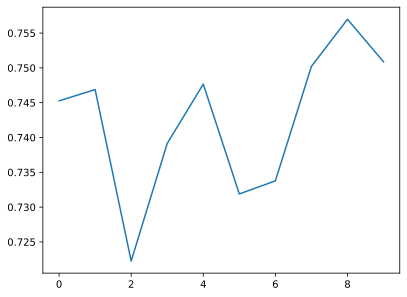

In [137]:
cb_validate(df, full_cols, cat_features=cat_features)

Закодируем категориальные признаки.

In [147]:
df = pd.get_dummies(data=df, columns=cat_features, drop_first=True)

In [149]:
cols = df.columns[1:].tolist()

0it [00:00, ?it/s]

0:	learn: 0.6011418	test: 0.6100937	best: 0.6100937 (0)	total: 54.2ms	remaining: 54.1s
100:	learn: 0.6753299	test: 0.6793106	best: 0.6793106 (100)	total: 2.14s	remaining: 19s
200:	learn: 0.7197460	test: 0.7254633	best: 0.7255936 (199)	total: 4.17s	remaining: 16.6s
300:	learn: 0.7312381	test: 0.7334301	best: 0.7354923 (259)	total: 8.45s	remaining: 19.6s
400:	learn: 0.7354180	test: 0.7398073	best: 0.7405686 (381)	total: 10.4s	remaining: 15.5s
500:	learn: 0.7386468	test: 0.7429762	best: 0.7438635 (486)	total: 12.3s	remaining: 12.2s
600:	learn: 0.7402370	test: 0.7436043	best: 0.7446202 (535)	total: 14.2s	remaining: 9.42s
700:	learn: 0.7420390	test: 0.7440140	best: 0.7447720 (697)	total: 16.2s	remaining: 6.89s
800:	learn: 0.7441182	test: 0.7464155	best: 0.7465456 (780)	total: 19.7s	remaining: 4.89s
900:	learn: 0.7453806	test: 0.7475615	best: 0.7476918 (848)	total: 22.4s	remaining: 2.47s
999:	learn: 0.7455640	test: 0.7485769	best: 0.7495618 (962)	total: 24.3s	remaining: 0us

bestTest = 0.749

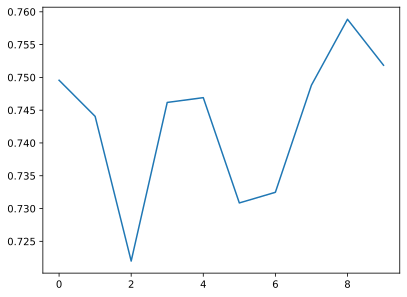

In [151]:
cb_validate(df, cols, cat_features=None)

In [152]:
with open("features_names.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join(cols))

Соберём пул полных данных и обучим классификатор на нём. Сейвим полученные веса.

In [156]:
full_train_pool = cb.Pool(
    df[cols],
    df["SeriousDlqin2yrs"],
    cat_features=None,
)

In [157]:
clf = cb.CatBoostClassifier(random_seed=5432, early_stopping_rounds=200, eval_metric="F1", verbose=200)
clf.fit(full_train_pool, eval_set=None)

Learning rate set to 0.081863
0:	learn: 0.6563629	total: 57.2ms	remaining: 57.2s
200:	learn: 0.7257330	total: 7.19s	remaining: 28.6s
400:	learn: 0.7354140	total: 14.6s	remaining: 21.8s
600:	learn: 0.7413793	total: 21.7s	remaining: 14.4s
800:	learn: 0.7458120	total: 29.8s	remaining: 7.39s
999:	learn: 0.7506932	total: 35.8s	remaining: 0us


In [158]:
clf.save_model("weights/clf")

In [159]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,NumberOfTimes90DaysLate,21.997272
1,RevolvingUtilizationOfUnsecuredLines,18.096445
2,NumberOfTime60-89DaysPastDueNotWorse,13.083704
3,DebtRatio,10.962328
4,NumberOfTime30-59DaysPastDueNotWorse,9.674305
5,MonthlyIncome,8.460067
6,NumberOfOpenCreditLinesAndLoans,7.250271
7,NumberOfDependents,5.154294
8,GroupAge_e,1.677823
9,GroupAge_d,1.359812
